In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/datasets")

Mounted at /content/drive


#Importando bibliotecas

In [ ]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision.datasets import CIFAR10
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 7500
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  7500


#Preparando o Ambiente

In [ ]:
# Root
dataroot = "/content/drive/My Drive/datasets/data2"
# Number of workers for dataloader
workers = 2

# Batch size e image size
batch_size = 64
image_size = 64

# Latent vector 
z_dim = 64

# Feature maps
features_generator = 128
features_discriminator = 128

# Numero de epocas
num_epochs = 70

# Learning rate
lr_g = 0.0002
lr_d = 0.0002

# Beta hyperparam (Adam)
beta1 = 0.5
beta2 = 0.999

#critic lambda
c_lambda = 10

display_step = 25

crit_repeats = 5

2278


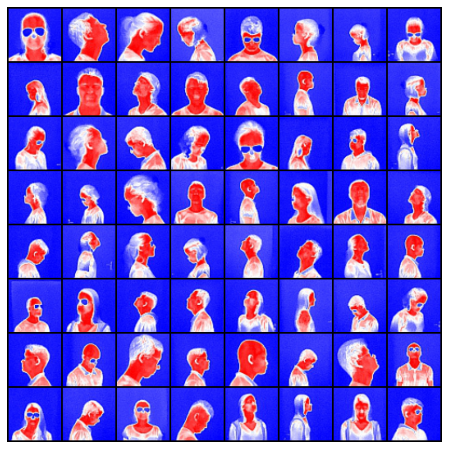

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset e normalizando em [-1,1]
dataset = dset.ImageFolder(dataroot, transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

#verify amount of images loaded
print(len(dataloader.dataset))

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim,features):
        super(Generator, self).__init__()
        # input is Z, going into a convolution
        self.block1 = self.gen_block(z_dim, features * 8, 4, 1, 0, False)
        # state size. (features*8) x 4 x 4
        self.block2 = self.gen_block(features * 8, features * 4, 4, 2, 1, False)
        # state size. (ngf*4) x 8 x 8
        self.block3 = self.gen_block(features * 4, features * 2, 4, 2, 1, False)
        # state size. (ngf*2) x 16 x 16
        self.block4 = self.gen_block(features * 2, features, 4, 2, 1, False)
        # state size. (ngf) x 32 x 32
        self.block5 = self.gen_block(features, 3, 4, 2, 1, True)

    def gen_block(self, input_channels, output_channels, kernel_size, stride, padding, final=False):
        if not final:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.1, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias=False),
                nn.Tanh()
            )

    def forward(self, input):
        x = self.block1(input)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        return x       

class Critic(nn.Module):
    def __init__(self, features):
        super(Critic, self).__init__()

        self.block1 = self.gen_block(3, features, 4, 2, 1)
        # state size. (features) x 32 x 32
        self.block2 = self.gen_block(features, features * 2, 4, 2, 1)
        # state size. (features*2) x 16 x 16
        self.block3 = self.gen_block(features * 2, features * 4, 4, 2, 1)
        # state size. (features*4) x 8 x 8
        self.block4 = self.gen_block(features * 4, features * 8, 4, 2, 1)
        # state size. (features*8) x 4 x 4
        self.block5 = self.gen_block(features * 8, 1, 4, 1, 0, True)
        

    def gen_block(self, input_channels, output_channels, kernel_size, stride, padding, final=False):
        if not final:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias=False),
                nn.InstanceNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias=False),
                #nn.Sigmoid()
            )

    def forward(self, input):
        x = self.block1(input)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.block5(x)

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = -torch.mean(crit_real_pred-crit_fake_pred) + (gp * c_lambda)
    return crit_loss

def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - 1) ** 2)
    #### END CODE HERE ####
    return penalty

In [ ]:
# Create the generator
netG = Generator(z_dim,features_generator).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Critic(features_discriminator).to(device)
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, beta2))


Generator(
  (block1): Sequential(
    (0): ConvTranspose2d(64, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (block2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (block3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (block4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
iters = 0
generator_losses = []
critic_losses = []
img_list = []
def show_tensor_images(image_tensor):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    #plt.title("Fake Images")
    plt.imshow(np.transpose(image_tensor,(1,2,0)))
    plt.show()


fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        mean_iteration_critic_loss = 0

        for _ in range(crit_repeats):
            ### Update critic ###
            optimizerD.zero_grad()
            #gen fake noise
            fake_noise = torch.randn(b_size, z_dim, 1, 1, device=device)
            fake = netG(fake_noise)
            crit_fake_pred = netD(fake.detach())
            crit_real_pred = netD(real_cpu)

            epsilon = torch.rand(len(real_cpu), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(netD, real_cpu, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            optimizerD.step()

        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        optimizerG.zero_grad()
        fake_noise_2 = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake_2 = netG(fake_noise_2)
        crit_fake_pred = netD(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        optimizerG.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):

            gen_mean = sum(generator_losses[-500:]) / 500
            crit_mean = sum(critic_losses[-500:]) / 500
            print(f"Epoch {epoch}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            with torch.no_grad():
              fake_eval = netG(fixed_noise).detach().cpu()
            #plotando imagens
            show_tensor_images(vutils.make_grid(fake_eval, padding=2, normalize=True))

            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins            
        iters += 1




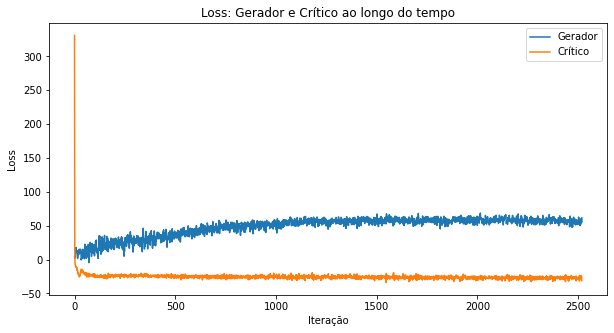

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss: Gerador e Crítico ao longo do tempo")
plt.plot(generator_losses,label="Gerador")
plt.plot(critic_losses,label="Crítico")
plt.xlabel("Iteração")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
final = torch.randn(2200, z_dim, 1, 1, device=device)

with torch.no_grad():
    fake = netG(final).detach().cpu()

for count,el in enumerate(fake):
  print('gerando: ', 'resultados/wgan_06/results_'+ str(count) +'.png')
  vutils.save_image(el,'resultados/wgan_06/results_'+ str(count) +'.png',normalize=True)

print('fim')

gerando:  resultados/wgan_06/results_0.png
gerando:  resultados/wgan_06/results_1.png
gerando:  resultados/wgan_06/results_2.png
gerando:  resultados/wgan_06/results_3.png
gerando:  resultados/wgan_06/results_4.png
gerando:  resultados/wgan_06/results_5.png
gerando:  resultados/wgan_06/results_6.png
gerando:  resultados/wgan_06/results_7.png
gerando:  resultados/wgan_06/results_8.png
gerando:  resultados/wgan_06/results_9.png
gerando:  resultados/wgan_06/results_10.png
gerando:  resultados/wgan_06/results_11.png
gerando:  resultados/wgan_06/results_12.png
gerando:  resultados/wgan_06/results_13.png
gerando:  resultados/wgan_06/results_14.png
gerando:  resultados/wgan_06/results_15.png
gerando:  resultados/wgan_06/results_16.png
gerando:  resultados/wgan_06/results_17.png
gerando:  resultados/wgan_06/results_18.png
gerando:  resultados/wgan_06/results_19.png
gerando:  resultados/wgan_06/results_20.png
gerando:  resultados/wgan_06/results_21.png
gerando:  resultados/wgan_06/results_22.pn

In [ ]:
#!apt install imagemagick

In [ ]:
'''
import matplotlib
import matplotlib.animation as animation
from IPython.display import HTML

final = 'paper_128_64_05'
matplotlib.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save(final+'.gif', writer='imagemagick', fps=30)
plt.savefig(final+'.png')

HTML(ani.to_jshtml())
'''

'\nimport matplotlib\nimport matplotlib.animation as animation\nfrom IPython.display import HTML\n\nfinal = \'paper_128_64_05\'\nmatplotlib.rcParams[\'animation.embed_limit\'] = 2**128\nfig = plt.figure(figsize=(8,8))\nplt.axis("off")\nims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]\nani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)\nani.save(final+\'.gif\', writer=\'imagemagick\', fps=30)\nplt.savefig(final+\'.png\')\n\nHTML(ani.to_jshtml())\n'